In [843]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [844]:
train.head(10)

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller,1
1,1851,"Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw",1
2,2689,"one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot; {link}",2
3,4525,This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork,0
4,3604,Line outside the Apple store in Austin waiting for the new iPad #SXSW {link},1
5,966,#technews One lone dude awaits iPad 2 at AppleÛªs SXSW store {link} #Tech_News #Apple #iPad_2 #SXSW #tablets #tech,1
6,1395,"SXSW Tips, Prince, NPR Videos, Toy Shopping With Zuckerberg.\r\n{link} #sxsw #ipad",1
7,8182,NU user RT @mention New #UberSocial for #iPhone now in the App Store includes UberGuide to #SXSW sponsored by #Mashable,1
8,8835,Free #SXSW sampler on iTunes {link} #FreeMusic,2
9,883,I think I might go all weekend without seeing the same iPad case twice... #sxsw,2


In [845]:
train.sentiment.value_counts()

1    4311
2    2382
0    456 
3    125 
Name: sentiment, dtype: int64

In [846]:
def preprocessing_text(table):
    #put everything in lowercase
    table['tweet'] = table['tweet'].str.lower()
    #Replace rt indicating that was a retweet
    table['tweet'] = table['tweet'].str.replace('rt', '')
    #Replace occurences of mentioning @UserNames
    #table['tweet'] = table['tweet'].replace(r'@[^\s]+', 'AT_USER', regex=True)
    table['tweet'] = table['tweet'].replace(r'@[^\s]+', '', regex=True)
    table['tweet'] = table['tweet'].replace(r'link', '', regex=True)    
            
    #Replace links contained in the tweet
    table['tweet'] = table['tweet'].replace(r'((www\.[^\s]+)|(https?://[^\s]+))', 'URL', regex=True)
    #remove numbers
    table['tweet'] = table['tweet'].replace(r'[0-9]+', '', regex=True)
    #replace special characters and puntuation marks
    table['tweet'] = table['tweet'].replace(r'[!"$%&()*+,-./:;<=>?@[\]^_`{|}~]', '', regex=True)
    table['tweet'] = table['tweet'].replace(r'#([^\s]+)', r'\1', regex=True)
    
    table['tweet'] = table['tweet'].replace(['atuser', 'amp', "'s"], '', regex=True)
    
    return table

In [847]:
import re
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import (
    wordnet,
    stopwords
)

[nltk_data] Downloading package wordnet to C:\Users\THINK
[nltk_data]     PAD\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\THINK
[nltk_data]     PAD\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\THINK
[nltk_data]     PAD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\THINK PAD\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [848]:
def stop_words(table):
    #We need to remove the stop words
    stop_words_list = stopwords.words('english')
    table['tweet'] = table['tweet'].str.lower()
    table['tweet'] = table['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_list)]))
    return table

In [849]:
def in_dict(word):
    if wordnet.synsets(word):
        #if the word is in the dictionary, we'll return True
        return True

def replace_elongated_word(word):
    regex = r'(\w*)(\w+)\2(\w*)'
    repl = r'\1\2\3'    
    if in_dict(word):
        return word
    new_word = re.sub(regex, repl, word)
    if new_word != word:
        return replace_elongated_word(new_word)
    else:
        return new_word

def detect_elongated_words(row):
    regexrep = r'(\w*)(\w+)(\2)(\w*)'
    words = [''.join(i) for i in re.findall(regexrep, row)]
    for word in words:
        if not in_dict(word):
            row = re.sub(word, replace_elongated_word(word), row)
    return row

In [850]:

def replace_antonyms(word):
    #We get all the lemma for the word
    for syn in wordnet.synsets(word): 
        for lemma in syn.lemmas(): 
            #if the lemma is an antonyms of the word
            if lemma.antonyms(): 
                #we return the antonym
                return lemma.antonyms()[0].name()
    return word

In [851]:
def handling_negation(row):
    #Tokenize the row
    words = word_tokenize(row)
    speach_tags = ['JJ', 'JJR', 'JJS', 'NN', 'VB', 'VBD', 'VBG', 'VBN', 'VBP']
    #We obtain the type of words that we have in the text, we use the pos_tag function
    tags = nltk.pos_tag(words)
    #Now we ask if we found a negation in the words
    tags_2 = ''
    if "n't" in words and "not" in words:
        tags_2 = tags[min(words.index("n't"), words.index("not")):]
        words_2 = words[min(words.index("n't"), words.index("not")):]
        words = words[:(min(words.index("n't"), words.index("not")))+1]
    elif "n't" in words:
        tags_2 = tags[words.index("n't"):]
        words_2 = words[words.index("n't"):] 
        words = words[:words.index("n't")+1]
    elif "not" in words:
        tags_2 = tags[words.index("not"):]
        words_2 = words[words.index("not"):]
        words = words[:words.index("not")+1] 
        
    for index, word_tag in enumerate(tags_2):
        if word_tag[1] in speach_tags:
            words = words+[replace_antonyms(word_tag[0])]+words_2[index+2:]
            break
            
    return ' '.join(words)

In [852]:
def cleaning_table(table):
    #This function will process all the required cleaning for the text in our tweets
    table = preprocessing_text(table)
    table['tweet'] = table['tweet'].apply(lambda x: detect_elongated_words(x))
    table['tweet'] = table['tweet'].apply(lambda x: handling_negation(x))
    table = stop_words(table)
    return table

In [853]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7274 entries, 0 to 7273
Data columns (total 3 columns):
tweet_id     7274 non-null int64
tweet        7273 non-null object
sentiment    7274 non-null int64
dtypes: int64(2), object(1)
memory usage: 170.6+ KB


In [854]:
train.dropna(inplace=True)

In [855]:



train = cleaning_table(train)

In [856]:
test = cleaning_table(test)

In [857]:
train.head()

,tweet_id,tweet,sentiment
0,1701,sxswnui sxsw apple defining language touch different dialects becoming smaller,1
1,1851,learning ab google doodles doodles light funny innovative exceptions significant occasions gogledodle sxsw,1
2,2689,one inyourface ex stealing show yrs quotat sxsw apple schools mkt expesquot,2
3,4525,iphone sxsw ap would b pretty awesome n't crash mins extended browsing fuckit ilmakeitwork,0
4,3604,line outside apple store austin waiting new ipad sxsw,1


In [858]:
pd.set_option('display.max_colwidth', -1)
print(train.tweet[:10])

0    sxswnui sxsw apple defining language touch different dialects becoming smaller                            
1    learning ab google doodles doodles light funny innovative exceptions significant occasions gogledodle sxsw
2    one inyourface ex stealing show yrs quotat sxsw apple schools mkt expesquot                               
3    iphone sxsw ap would b pretty awesome n't crash mins extended browsing fuckit ilmakeitwork                
4    line outside apple store austin waiting new ipad sxsw                                                     
5    technews one lone dude awaits ipad appleûªs sxsw store technews apple ipad sxsw tablets tech             
6    sxsw tips prince npr videos toy shopping zuckerberg sxsw ipad                                             
7    nu user new ubersocial iphone ap store includes uberguide sxsw sponsored mashable                         
8    free sxsw sler itunes fremusic                                                                     

In [859]:
pd.set_option('display.max_colwidth', -1)
print(test.tweet[:10])

0    audience q protyping tools use sketchboksharpie pens photoshop balsamic google docs axsure etc myprotype sxsw
1    sxsw send best photos videos citizenjournalism cn irepo photography sxsw cyber iphone                        
2    pic winning ipad unsix sxsw cc cont                                                                          
3    google marisa mayer mobile phone cursor physical location new version map fast real life like sxsw           
4    sxsw google maps even cooler thought                                                                         
5    front popup store sxsw last night                                                                            
6    next life 'm coming back ipad women ca n't discontinue hands thing sxsw                                      
7    google celebrating pi day style sxsw                                                                         
8    hm bit weird sxsw tending google circle                                    

In [860]:
from nltk.stem.porter import *
train['tokenized_tweet'] = [nltk.word_tokenize(x) for x in train['tweet']]
stemmer = PorterStemmer()
train['tokenized_tweet'] = train['tokenized_tweet'].apply(lambda x: [stemmer.stem(i) for i in x])
train['tokenized_tweet'] = train['tokenized_tweet'].apply(lambda x: ' '.join(x))
train.head(15)

,tweet_id,tweet,sentiment,tokenized_tweet
0,1701,sxswnui sxsw apple defining language touch different dialects becoming smaller,1,sxswnui sxsw appl defin languag touch differ dialect becom smaller
1,1851,learning ab google doodles doodles light funny innovative exceptions significant occasions gogledodle sxsw,1,learn ab googl doodl doodl light funni innov except signific occas gogledodl sxsw
2,2689,one inyourface ex stealing show yrs quotat sxsw apple schools mkt expesquot,2,one inyourfac ex steal show yr quotat sxsw appl school mkt expesquot
3,4525,iphone sxsw ap would b pretty awesome n't crash mins extended browsing fuckit ilmakeitwork,0,iphon sxsw ap would b pretti awesom n't crash min extend brows fuckit ilmakeitwork
4,3604,line outside apple store austin waiting new ipad sxsw,1,line outsid appl store austin wait new ipad sxsw
5,966,technews one lone dude awaits ipad appleûªs sxsw store technews apple ipad sxsw tablets tech,1,technew one lone dude await ipad appleûª sxsw store technew appl ipad sxsw tablet tech
6,1395,sxsw tips prince npr videos toy shopping zuckerberg sxsw ipad,1,sxsw tip princ npr video toy shop zuckerberg sxsw ipad
7,8182,nu user new ubersocial iphone ap store includes uberguide sxsw sponsored mashable,1,nu user new ubersoci iphon ap store includ uberguid sxsw sponsor mashabl
8,8835,free sxsw sler itunes fremusic,2,free sxsw sler itun fremus
9,883,think might go weekend without seeing ipad case twice sxsw,2,think might go weekend without see ipad case twice sxsw


In [861]:
test['tokenized_tweet'] = [nltk.word_tokenize(x) for x in test['tweet']]
stemmer = PorterStemmer()
test['tokenized_tweet'] = test['tokenized_tweet'].apply(lambda x: [stemmer.stem(i) for i in x])
test['tokenized_tweet'] = test['tokenized_tweet'].apply(lambda x: ' '.join(x))
test.head(15)

,tweet_id,tweet,tokenized_tweet
0,7506,audience q protyping tools use sketchboksharpie pens photoshop balsamic google docs axsure etc myprotype sxsw,audienc q protyp tool use sketchboksharpi pen photoshop balsam googl doc axsur etc myprotyp sxsw
1,7992,sxsw send best photos videos citizenjournalism cn irepo photography sxsw cyber iphone,sxsw send best photo video citizenjourn cn irepo photographi sxsw cyber iphon
2,247,pic winning ipad unsix sxsw cc cont,pic win ipad unsix sxsw cc cont
3,7688,google marisa mayer mobile phone cursor physical location new version map fast real life like sxsw,googl marisa mayer mobil phone cursor physic locat new version map fast real life like sxsw
4,3294,sxsw google maps even cooler thought,sxsw googl map even cooler thought
5,6125,front popup store sxsw last night,front popup store sxsw last night
6,6131,next life 'm coming back ipad women ca n't discontinue hands thing sxsw,next life 'm come back ipad women ca n't discontinu hand thing sxsw
7,4134,google celebrating pi day style sxsw,googl celebr pi day style sxsw
8,8206,hm bit weird sxsw tending google circle,hm bit weird sxsw tend googl circl
9,8552,launch 'circles ' later today sxsw gota love sxsw one platform everything independent film innovative tech,launch 'circl ' later today sxsw gota love sxsw one platform everyth independ film innov tech


In [862]:
data=train[["tweet", "sentiment"]]
len(data.tweet[0])
#len(data.tweet[0])

78

In [863]:
#data.tweet=data.tweet.str.split()


In [864]:
data.iloc[7271]

tweet        launched ipad ap sxsw get details first edition free
sentiment    1                                                   
Name: 7272, dtype: object

In [865]:
''''''''''import matplotlib.pyplot as plt
import seaborn as sn

sn.set(rc={'figure.figsize':(11,8)})
nlp_words=nltk.FreqDist(data.tweet)
nlp_words.plot()

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-865-2e0abb38844b>, line 6)

In [ ]:
from collections import Counter
x=[]
for i in range(len(data.tweet)):
    x.append(Counter(data.tweet.iloc[i]))
print(x[7271])

In [ ]:
list1=["apple", "ipad", 'ap', "iphone", "mac"]
sent1=[]
for i in range(10):
    for w in list1:
        #print(w)
        if w in data.tweet[i]:
            #print(w)
            #print(data.tweet[i])
            sent1.append(data.sentiment[i])
            

print(sent1)
print(data.tweet.iloc[:4])
    

In [ ]:
hi

In [ ]:
a=data[["tweet"]]
a

In [ ]:
'''''''''from sklearn.feature_extraction.text import CountVectorizer

cv=CountVectorizer()
vector=cv.fit_transform(data.tweet)
X=vector.toarray().tolist()

data.tweet
X

In [ ]:
#Plot the WordCloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.figure(figsize=(10,15))
allWords=' '.join([twts for twts in train['tweet']])
wordCloud= WordCloud(width=500,height=300,random_state=21,max_font_size=119).generate(allWords)
plt.imshow(wordCloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# google, google social, circles,marisa mayer, pay, doodle
# appple, ipad, apple store, popup, music-itune, iphone, 

In [ ]:
''''''''''glist=["google", "social", "circles","marisa mayer", "pay", "doodle"]
elist=[]

for g in glist:
    for i in len(train.tweet):
        if g in train.tweet[i]:
            elist.append(train.sentiment[i])
            
            


In [ ]:
# Positive words
t=train[train.sentiment==2]
plt.figure(figsize=(10,15))
allWords=' '.join([twts for twts in t['tweet']])
wordCloud= WordCloud(width=500,height=300,random_state=21,max_font_size=119).generate(allWords)
plt.title(" Positive Tweets")
plt.imshow(wordCloud,interpolation='bilinear')
plt.axis('off')
plt.show()

#
- ipad, iphone, google, android
- noise around google launch- circle and social, google pay
- what are they talking about? 
- 1) A lot of buzz around Google's new social network Circle launch
2) google map
3) Apple pop up store
4) iphone, android, ipad- there was an event called "ipad's design headache: take two tablets and call me in the morning "
- by josh clark, he could be an influencer and apple could have him do more events in the future.

5) ipad-2 launch 954 positive tweets



In [ ]:
t=train[train.sentiment==0]
plt.figure(figsize=(10,15))
allWords=' '.join([twts for twts in t['tweet']])
wordCloud= WordCloud(width=500,height=300,random_state=21,max_font_size=119).generate(allWords)
plt.imshow(wordCloud,interpolation='bilinear')
plt.title("Negative Tweets")
plt.axis('off')
plt.show()

In [ ]:
# long hour, long line, launch fail, twitter, tweet
#ipad, iphone, apple store, iphone battery, 
#ipad design headaches by josh clark- powerful inflencer
#google Social circle-----No positive news around it.

In [ ]:
t=train[train.sentiment==3]
plt.figure(figsize=(10,15))
allWords=' '.join([twts for twts in t['tweet']])
wordCloud= WordCloud(width=500,height=300,random_state=21,max_font_size=119).generate(allWords)
plt.imshow(wordCloud,interpolation='bilinear')
plt.title("Cant Tell Tweets")
plt.axis('off')
plt.show()

list1=["apple", "ipad", "iphone", "goole", "social", "circle", "itunes", "doodle", "mayer"]
#list1=["aple"]
sent1=[]
for w in list1:
    for i in range((1200)):
    
        #print(w)
        if w in train.tweet[i]:
            #print(w)
            #print(data.tweet[i])
            sent1.append(w)
            

#print(sent1)
#print(data.tweet.iloc[:4])


s=pd.DataFrame(sent1)
#s.value_counts()
s.columns=["words"]# rename(columns={0: "words"}) would also work
s.words.value_counts()

len(data)


In [ ]:
from collections import Counter

#data.tweet=data.tweet.str.split()
#
data.tweet

# Most tweeted words

In [ ]:
import plotly
from plotly.offline import iplot
import pandas as pd
import plotly.graph_objs as go
import cufflinks
from plotly.offline import init_notebook_mode



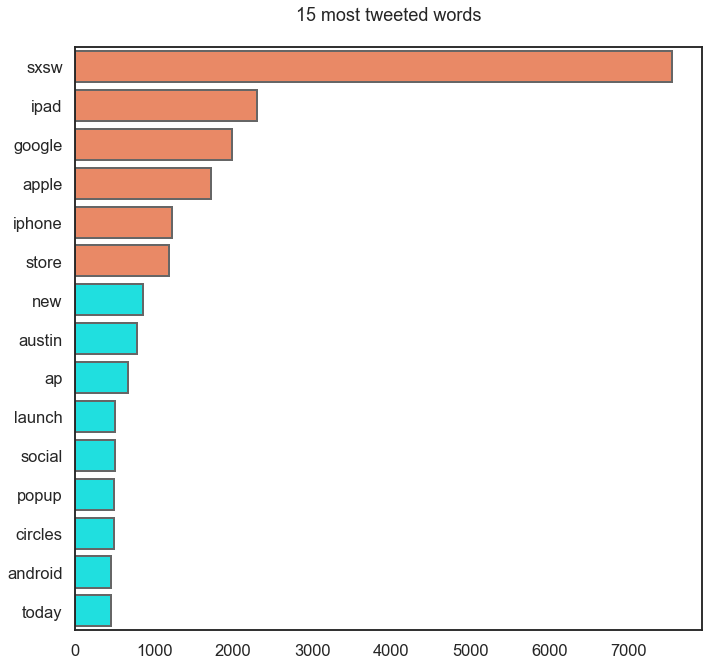

In [867]:
data.tweet.replace("n't", '', regex=True, inplace=True)

import seaborn as sn
    
cv=[]

#concat all the rows in one large sentence
cv=data.tweet.str.cat(sep=" ")

#separate each word by ,
y=cv.split()

#Count frequency of 20 top words 
X=Counter(y).most_common(15)

# convert into a df
X=pd.DataFrame(X)
X.columns=["Words", "Frequency"]
plt.figure(figsize=(10,10))

sn.set_style("white")
#sn.despine(offset=10, trim=True)
#sn.set(font_scale=1)
sn.despine()
sn.set_context("talk")


plt.title("15 most tweeted words\n")
clrs = ['aqua' if (x < 1000) else 'coral' for x in X.Frequency ]
g=sn.barplot(y="Words", x="Frequency", palette= clrs, data=X,linewidth=2,
                   edgecolor=".4" )
plt.xlabel("")
plt.ylabel("")


#sn.set_style("ticks")
sn.set(font_scale=1)
plt.show()


pos=train[train.sentiment==2]
p=["ipad"]
sent1=[]
for i in range(len(pos)):
    if p in p[i]:############### p cant be in p[i]
            #print(w)
            #print(data.tweet[i])
            sent1.append(w)


X.iplot(kind='bar', xTitle='Frequency', yTitle='Words', title='Most Tweeted Words')
layout=dict(template="plotly_dark")

trace=go.Bar(x=X.Words, y=X.Frequency, name="Most Tweeted Words", text=)

In [870]:
cv=[]

#concat all the rows in one large sentence
cv=data.tweet.str.cat(sep=" ")

#separate each word by ,
y=cv.split()

#Count frequency of 20 top words 
X=Counter(y).most_common(15)

# convert into a df
X=pd.DataFrame(X)
X.columns=["Words", "Frequency"]
X

,Words,Frequency
0,sxsw,7551
1,ipad,2301
2,google,1986
3,apple,1718
4,iphone,1223
5,store,1188
6,new,861
7,austin,784
8,ap,664
9,launch,510


# products with most positive tweets

    Words  Frequency
0  ipad    963      
1  apple   663      
2  google  543      
3  iphone  427      
4  store   419      


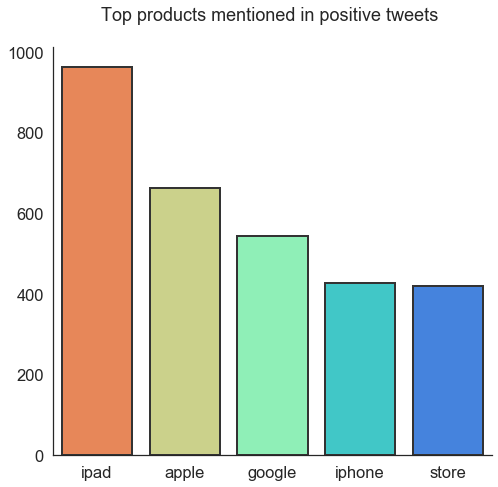

In [560]:
cv=[]
#for i in range(7273):
data.tweet.replace(["sxsw"], '', regex=True, inplace=True)

data1=data[data.sentiment==2]

cv=data1.tweet.str.cat(sep=" ")


y=cv.split()
X=Counter(y).most_common(5)
X=pd.DataFrame(X)
X.columns=["Words", "Frequency"]
print(X)
plt.figure(figsize=(7,7))
sn.set_style("white")

g=sn.barplot(x="Words", y="Frequency", data=X, palette="rainbow_r", linewidth=2,
                   edgecolor=".2")

sn.despine()
#sn.despine(offset=10, trim=True)
#sn.set_context("notebook")
#sn.set_context("paper")


plt.title("Top products mentioned in positive tweets \n")
          #, fontsize=20)
#g.set_yticklabels(X.Words, size = 15)
#plt.ytick(fontsize = 15)
g.set_xlabel("")
g.set_ylabel("")
sn.set(font_scale=1.5)
#plt.xlabel(
plt.show()
#X


# Product with most Negative tweets

    Words  Frequency
0  ipad    161      
1  iphone  128      
2  google  111      
3  apple   83       
4  ap      50       


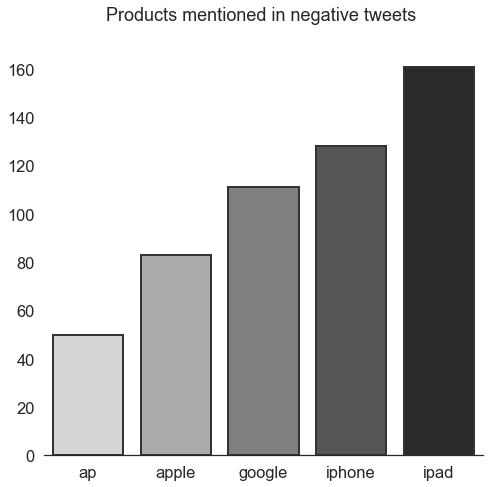

In [821]:
cv=[]
#for i in range(7273):
data.tweet.replace(["sxsw"], '', regex=True, inplace=True)

data2=data[data.sentiment==0]

cv=data2.tweet.str.cat(sep=" ")


y=cv.split()
X=Counter(y).most_common(5)
X=pd.DataFrame(X)
X.columns=["Words", "Frequency"]
print(X)
#X.plot(kind='bar')
plt.figure(figsize=(7,7))
sn.set_style("white")

#clrs = ['skyblue' if (x < X.Frequency.max()) else 'red' for x in X.Frequency ]
g=sn.barplot(x="Words", y="Frequency", data=X, palette="binary", linewidth=2,
                   edgecolor=".2", order=["ap", "apple", "google", "iphone", "ipad"])
sn.set(font_scale=1.5)

#sn.despine(offset=10, trim=True)
#sn.set_context("notebook")
#sn.set_context("paper")
#sn.set(font_scale=1.5)
plt.title("Products mentioned in negative tweets \n")
          #, fontsize=20)
#g.set_yticklabels(X.Words, size = 15)
#plt.ytick(fontsize = 15)
g.set_xlabel("")
g.set_ylabel("")
sn.despine(left=True)


#plt.xlabel(
plt.show()


In [302]:
# Neutral tweets

    Words  Frequency
0  google  1295     
1  ipad    1135     
2  apple   943      
3  store   714      
4  iphone  644      


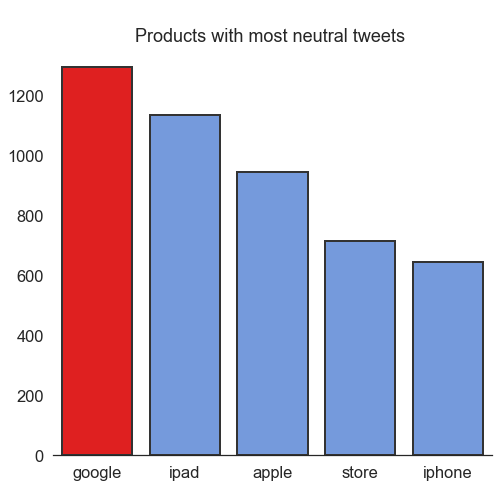

In [834]:
cv=[]
#for i in range(7273):
data.tweet.replace(["sxsw"], '', regex=True, inplace=True)

data2=data[data.sentiment==1]

cv=data2.tweet.str.cat(sep=" ")


y=cv.split()
X=Counter(y).most_common(5)
X=pd.DataFrame(X)
X.columns=["Words", "Frequency"]
print(X)
#X.plot(kind='bar')
plt.figure(figsize=(7,7))
sn.set_style("white")

clrs = ['red' if (x == X.Frequency.max()) else 'cornflowerblue' for x in X.Frequency ]
g=sn.barplot(x="Words", y="Frequency", data=X, palette=clrs, linewidth=2,
                   edgecolor=".2", )
#sn.despine(offset=10, trim=True)
#sn.set_context("notebook")
#sn.set_context("paper")
sn.set(font_scale=1.5)
plt.title("\nProducts with most neutral tweets ")
          #, fontsize=20)
#g.set_yticklabels(X.Words, size = 15)
#plt.ytick(fontsize = 15)
sn.despine(left=True)

g.set_xlabel("")
g.set_ylabel("")

#plt.xlabel(
plt.show()


     Words  Frequency
0  ipad     43       
1  google   37       
2  apple    29       
3  iphone   25       
4  store    17       
5  austin   13       
6  like     10       
7  circles  8        
8  line     7        
9  popup    7        


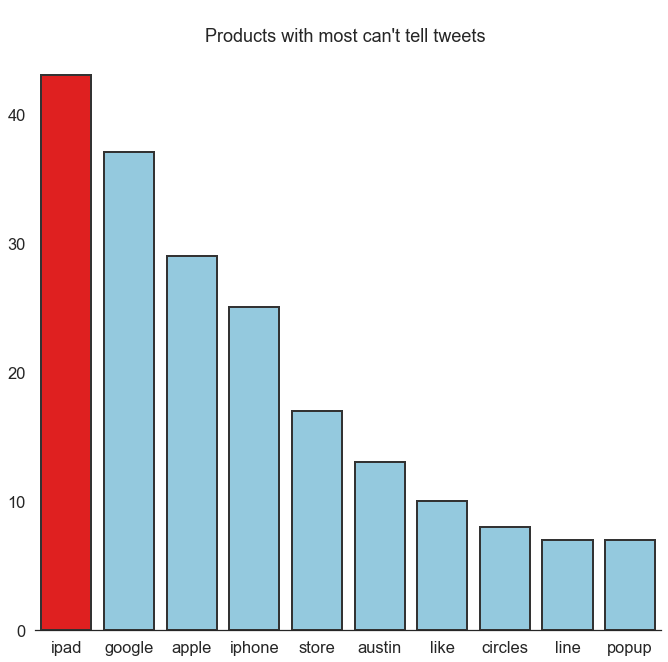

In [833]:
cv=[]
#for i in range(7273):
data.tweet.replace(["sxsw"], '', regex=True, inplace=True)

data2=data[data.sentiment==3]

cv=data2.tweet.str.cat(sep=" ")


y=cv.split()
X=Counter(y).most_common(10)
X=pd.DataFrame(X)
X.columns=["Words", "Frequency"]
print(X)
#X.plot(kind='bar')
plt.figure(figsize=(10,10))
sn.set_style("white")

clrs = ['skyblue' if (x < X.Frequency.max()) else 'red' for x in X.Frequency ]
g=sn.barplot(x="Words", y="Frequency", data=X, palette=clrs, edgecolor=".2", linewidth=2)
sn.despine(left=True)
#sn.set_context("notebook")
#sn.set_context("paper")
sn.set(font_scale=1.5)
plt.title("\nProducts with most can't tell tweets ")
          #, fontsize=20)
#g.set_yticklabels(X.Words, size = 15)
#plt.ytick(fontsize = 15)
g.set_xlabel("")
g.set_ylabel("")

#plt.xlabel(
plt.show()


In [305]:

#count number of tweets

In [306]:
#data2=data[data.sentiment==2
rev=data.copy()
rev.tweet=rev.tweet.str.split()


In [321]:
rev.head()

,tweet,sentiment
0,"[nui, apple, defining, language, touch, different, dialects, becoming, smaller]",1
1,"[learning, ab, google, doodles, doodles, light, funny, innovative, exceptions, significant, occasions, gogledodle]",1
2,"[one, inyourface, ex, stealing, show, yrs, quotat, apple, schools, mkt, expesquot]",2
3,"[iphone, ap, would, b, pretty, awesome, crash, mins, extended, browsing, fuckit, ilmakeitwork]",0
4,"[line, outside, apple, store, austin, waiting, new, ipad]",1


In [503]:
rev.head()
i="ipad"
l=[]

for x in range(len(rev)):
    if i in rev.iloc[x,0]:
        l.append(rev.iloc[x,1])
    
#print(rev.tweet, rev.sentiment)


#lit=pd.DataFrame(lit)
#lit=lit[0]
l=pd.DataFrame(l)
l.columns=["sentiment"]
l.sentiment.value_counts()




1    1058
2    903 
0    142 
3    41  
Name: sentiment, dtype: int64

In [504]:
# Changing values
def senti(l):
    for i in range(len(l)):
        if l.iloc[i,0]==0:
            l.iloc[i,0]="Negative"
        elif l.iloc[i,0]==1:
            l.iloc[i,0]="Neutral"
        elif l.iloc[i,0]==2:
            l.iloc[i,0]="Positive"
        elif l.iloc[i,0]==3:
            l.iloc[i,0]="Can't Tell"

Neutral       1058
Positive      903 
Negative      142 
Can't Tell    41  
Name: sentiment, dtype: int64


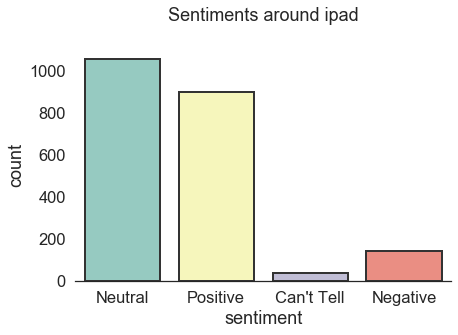

In [578]:
print(l.sentiment.value_counts())
senti(l)
sn.set_style("white")

sn.countplot(x="sentiment", data=l, palette="Set3",  linewidth=2, edgecolor=".2", )
            # order=["Neutral", "Positive", "Negative", "Cant Tell"])
#g=sn.barplot(x="Words", y="Frequency", data=X, palette="binary_r", linewidth=2,
                   #edgecolor=".2")
#sn.set(font_scale=1.5)

sn.despine(left=True)
#sn.set_context("notebook")
#sn.set_context("paper")
#sn.set(font_scale=1.5)
plt.title("Sentiments around ipad\n")
          #, fontsize=20)
#g.set_yticklabels(X.Words, size = 15)
#plt.ytick(fontsize = 15)
g.set_xlabel("")
g.set_ylabel("")

#plt.xlabel(
plt.show()


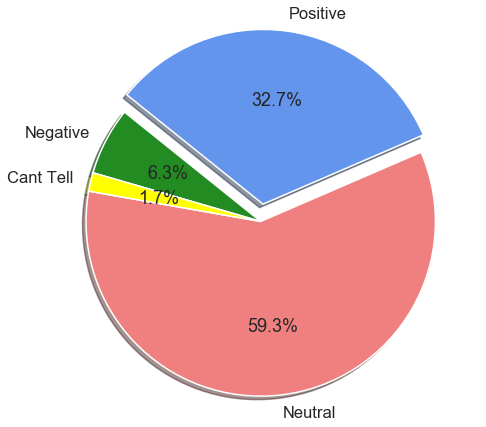

In [839]:
labels = 'Neutral', 'Positive', 'Negative', 'Cant Tell'
#sizes = [15, 30, 45, 10]
explode = (0, 0.1, 0, 0)
colors = [ 'lightcoral','cornflowerblue', 'forestgreen', 'yellow']
plt.figure(figsize=(7,7))
sn.set_context("talk")
plt.pie(train.sentiment.value_counts(), colors=colors, labels=labels, explode=explode, autopct='%1.1f%%',
         shadow=True,startangle=170)
plt.axis("equal")
plt.show()

In [520]:
train.sentiment.value_counts()


1    4310
2    2382
0    456 
3    125 
Name: sentiment, dtype: int64

In [603]:
i="apple"
a=[]

for x in range(len(rev)):
    if i in rev.iloc[x,0]:
        a.append(rev.iloc[x,1])
    
#print(rev.tweet, rev.sentiment)


#lit=pd.DataFrame(lit)
#lit=lit[0]
a=pd.DataFrame(a)
a.columns=["sentiment"]
senti(a)
a.sentiment.value_counts()


Neutral       858
Positive      595
Negative      78 
Can't Tell    25 
Name: sentiment, dtype: int64

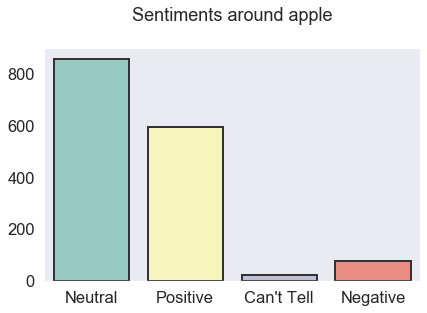

In [604]:
#l.sentiment.value_counts()

sn.countplot(x="sentiment", data=a, palette="Set3",  linewidth=2,
                   edgecolor=".2")
#g=sn.barplot(x="Words", y="Frequency", data=X, palette="binary_r", linewidth=2,
                   #edgecolor=".2")
sn.set_style("dark")
#sn.set(font_scale=1.5)

#sn.despine(offset=10, trim=True)
#sn.set_context("notebook")
#sn.set_context("paper")
#sn.set(font_scale=1.5)
plt.title("Sentiments around "+i+ "\n")
          #, fontsize=20)
#g.set_yticklabels(X.Words, size = 15)
#plt.ytick(fontsize = 15)
plt.xlabel("")
plt.ylabel("")


#plt.xlabel(
plt.show()


# Was it a positive platform for ipad
- Since Negative Sentiments for apple and ipad were <7% whereas the overall performance of the event was good. 
- of all the tweets it was mentioned in ipad had 42% positive tweets it had 903 oout of 2382 tweets ie. 37% of all the 
  positive tweets were garnered by ipad
- design related negative tweets were mostly about the talk by Josh clark called  “iPad Design Headaches: Take Two Tablets and Call Me in the Morning.” and they were people just mentions
- Since ipad2 was being launched, some tweets were about long lines, out of stock, and some were by android users.
- There was speculation around the launch of circle by Google, there were quite a few discouraging remarks about the possible luanch. Sentiments were cold.
- for apple, conversation's were around battery, money, store, line, network
- For google, there were conversation around Marissa Mayer, Google map, 


In [523]:
data3=data[data.sentiment==0]

cv=data3.tweet.str.cat(sep=" ")


y1=cv.split()
X1=Counter(y1).most_common(60)
X1=pd.DataFrame(X1)
X1.columns=["Words", "Frequency"]
print(X1)


        Words  Frequency
0   ipad       161      
1   iphone     128      
2   google     111      
3   apple      83       
4   ap         50       
5   store      38       
6   like       33       
7   new        31       
8   circles    28       
9   design     26       
10  austin     23       
11  aps        21       
12  social     21       
13  people     21       
14  android    19       
15  go         18       
16  '          17       
17  get        17       
18  would      16       
19  today      16       
20  fail       16       
21  launch     16       
22  need       15       
23  've        15       
24  think      15       
25  day        14       
26  time       14       
27  'm         14       
28  line       14       
29  headaches  14       
30  see        14       
31  users      13       
32  back       13       
33  battery    13       
34  says       13       
35  one        13       
36  news       12       
37  popup      12       
38  really     11       


# negative grievances sorted, # positives to be looked into to evaluate 
- "Was the event a successful platform for the products? How was the overall experience?"
- Can the cant'tell be better interpreted? for this subset look at frquent words
- Within the brand, which product or feature was most talked about? chart this out for eg for apple, ipad launch, 
and design headache event and iphone in general were most talk about. look for evidence to support and rationalise. 
- Do similar with google

In [600]:
i="google"
g=[]

for x in range(len(rev)):
    if i in rev.iloc[x,0]:
        g.append(rev.iloc[x,1])
    
#print(rev.tweet, rev.sentiment)


#lit=pd.DataFrame(lit)
#lit=lit[0]
g=pd.DataFrame(g)
g.columns=["sentiment"]
senti(g)
g.sentiment.value_counts()


Neutral       1193
Positive      504 
Negative      96  
Can't Tell    37  
Name: sentiment, dtype: int64

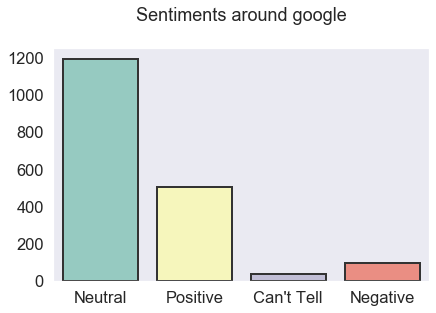

In [601]:
sn.countplot(x="sentiment", data=g, palette="Set3",  linewidth=2,
                   edgecolor=".2")
#g=sn.barplot(x="Words", y="Frequency", data=X, palette="binary_r", linewidth=2,
                   #edgecolor=".2")
sn.set_style("dark")
#sn.set(font_scale=1.5)

#sn.despine(offset=10, trim=True)
#sn.set_context("notebook")
#sn.set_context("paper")
#sn.set(font_scale=1.5)
plt.title("Sentiments around "+i+ "\n")
          #, fontsize=20)
#g.set_yticklabels(X.Words, size = 15)
#plt.ytick(fontsize = 15)
plt.xlabel("")
plt.ylabel("")

#plt.xlabel(
plt.show()


In [702]:
i=["google","apple", "ipad", "iphone"]
g=[]
w=[]
#print(len(rev))

for p in i:
    #print(p)
    for x in range(len(rev)):
        if p in rev.iloc[x,0]:
            #print(p, rev.iloc[x,1])
            w.append(p)
            g.append(rev.iloc[x,1])
    
#print(rev.tweet, rev.sentiment)
w=pd.DataFrame(w)

#lit=pd.DataFrame(lit)
#lit=lit[0]
g=pd.DataFrame(g)
g.columns=["sentiment"]
senti(g)

g["words"]=w
#g.append()


#g.sentiment.value_counts()
#print(g.words)
#len(w)
g.groupby("sentiment")["words"].value_counts().unstack().sort_values(by=["sentiment"], ascending=False)

words,apple,google,ipad,iphone
sentiment,,,,
Positive,595,504,903,422
Neutral,858,1193,1058,633
Negative,78,96,142,124
Can't Tell,25,37,41,24


In [751]:
'''''''''''plt.figure(figsize=(15,15))
g.groupby("sentiment")["words"].value_counts().unstack().sort_values(by=["sentiment"], ascending=False).plot(kind="bar")
plt.xticks(rotation='horizontal')
plt.show()'''

'\'\'plt.figure(figsize=(15,15))\ng.groupby("sentiment")["words"].value_counts().unstack().sort_values(by=["sentiment"], ascending=False).plot(kind="bar")\nplt.xticks(rotation=\'horizontal\')\nplt.show()'

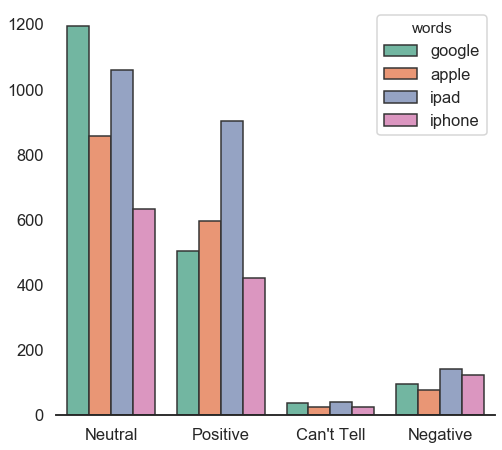

In [749]:
plt.figure(figsize=(7,7))
sn.countplot(x="sentiment", hue="words",palette='Set2', data=g, edgecolor=".2")
sn.set_style("white")
sn.set_context('talk')
sn.despine(left=True)
plt.ylabel("")
plt.xlabel("")
plt.show()


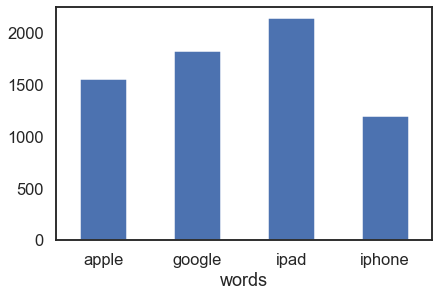

In [705]:
g.groupby("sentiment")["words"].value_counts().unstack().sum().plot(kind="bar")
plt.xticks(rotation='horizontal')
plt.show()

In [706]:
g.groupby("sentiment")["words"].value_counts().unstack().sum()

words
apple     1556
google    1830
ipad      2144
iphone    1203
dtype: int64

In [707]:
g.groupby("sentiment")["words"].value_counts().sum()

6733

In [806]:
train.sentiment.value_counts()

1    4311
2    2382
0    456 
3    125 
Name: sentiment, dtype: int64

In [807]:
train.shape

(7274, 3)

# words associated with ipad, apple and google

In [947]:

i="ipad"
a=[]

for x in range(len(rev)): #tweet with words separated
    if i in rev.iloc[x,0]:
        a.append(rev.iloc[x,0]) # appends each row as a list
    
for n in range(len(a)):
    a[n]=" ".join(a[n])

a=pd.DataFrame(a)
a.columns=["tweet"]

c=[]

#concat all the rows in one large sentence
c=a.tweet.str.cat(sep=" ")

#separate each word by , and created 
y=c.split()

#Count frequency of 20 top words 
X=Counter(y).most_common(20)

# convert into a df
X=pd.DataFrame(X)
#print(X)
#dropping ipad from the list
X.drop([0], axis=0,inplace=True)

X.columns=["Words", "Frequency"]
X

,Words,Frequency
1,apple,625
2,store,520
3,austin,317
4,popup,199
5,new,185
6,line,172
7,ap,149
8,launch,147
9,temporary,136
10,opening,124


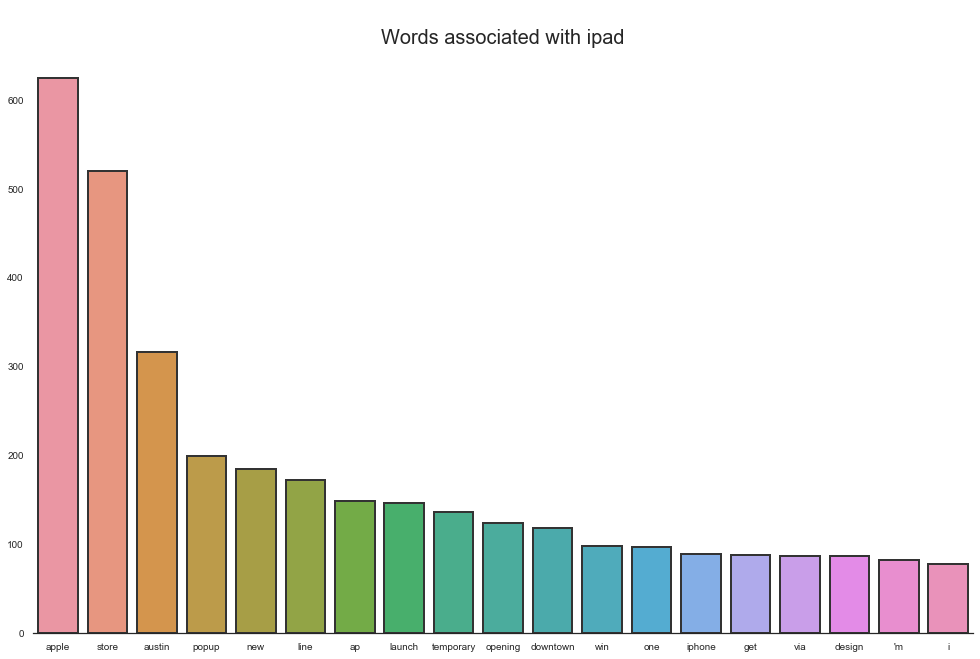

In [951]:
plt.figure(figsize=(15,10))
sn.set_style("white")

#clrs = ['skyblue' if (x < X.Frequency.max()) else 'red' for x in X.Frequency ]
g=sn.barplot(x="Words", y="Frequency", data=X, edgecolor=".2", linewidth=2)
sn.despine(left=True)
#sn.set_context("notebook")
#sn.set_context("talk")
sn.set(font_scale=.9)
plt.title("\nWords associated with ipad", fontsize=20)
#g.set_yticklabels(X.Words, size = 15)
#plt.ytick(fontsize = 15)
g.set_xlabel("")
g.set_ylabel("")

#plt.xlabel(
plt.show()


In [952]:
    i="microsoft"
    a=[]

    for x in range(len(rev)): #tweet with words separated
        if i in rev.iloc[x,0]:
            a.append(rev.iloc[x,0]) # appends each row as a list
    
    for n in range(len(a)):
        a[n]=" ".join(a[n])

    a=pd.DataFrame(a)
    a.columns=["tweet"]

    c=[]

#concat all the rows in one large sentence
    c=a.tweet.str.cat(sep=" ")

#separate each word by , and created 
    y=c.split()

#Count frequency of 20 top words 
    X=Counter(y).most_common(15)

# convert into a df
    X=pd.DataFrame(X)
#print(X)
#dropping ipad from the list
    X.drop([0], axis=0,inplace=True)

    X.columns=["Words", "Frequency"]
X

,Words,Frequency
1,apple,17
2,google,7
3,get,6
4,hour,5
5,iphone,4
6,facebok,4
7,go,4
8,ipad,4
9,lose,4
10,attendees,4


In [922]:
    i="apple"
    a=[]

    for x in range(len(rev)): #tweet with words separated
        if i in rev.iloc[x,0]:
            a.append(rev.iloc[x,0]) # appends each row as a list
    
    for n in range(len(a)):
        a[n]=" ".join(a[n])

    a=pd.DataFrame(a)
    a.columns=["tweet"]

    c=[]

#concat all the rows in one large sentence
    c=a.tweet.str.cat(sep=" ")

#separate each word by , and created 
    y=c.split()

#Count frequency of 20 top words 
    X=Counter(y).most_common(15)

# convert into a df
    X=pd.DataFrame(X)
#print(X)
#dropping ipad from the list
    X.drop([0], axis=0,inplace=True)

    X.columns=["Words", "Frequency"]
X

,Words,Frequency
1,store,970
2,ipad,611
3,popup,469
4,austin,392
5,line,225
6,temporary,153
7,opening,143
8,open,138
9,downtown,117
10,pop,111


In [923]:
    i="google"
    a=[]

    for x in range(len(rev)): #tweet with words separated
        if i in rev.iloc[x,0]:
            a.append(rev.iloc[x,0]) # appends each row as a list
    
    for n in range(len(a)):
        a[n]=" ".join(a[n])

    a=pd.DataFrame(a)
    a.columns=["tweet"]

    c=[]

#concat all the rows in one large sentence
    c=a.tweet.str.cat(sep=" ")

#separate each word by , and created 
    y=c.split()

#Count frequency of 20 top words 
    X=Counter(y).most_common(15)

# convert into a df
    X=pd.DataFrame(X)
#print(X)
#dropping ipad from the list
    X.drop([0], axis=0,inplace=True)

    X.columns=["Words", "Frequency"]
X

,Words,Frequency
1,circles,471
2,social,428
3,new,367
4,network,337
5,launch,317
6,today,273
7,called,252
8,major,214
9,possibly,174
10,maps,164


In [924]:
    i="android"
    a=[]

    for x in range(len(rev)): #tweet with words separated
        if i in rev.iloc[x,0]:
            a.append(rev.iloc[x,0]) # appends each row as a list
    
    for n in range(len(a)):
        a[n]=" ".join(a[n])

    a=pd.DataFrame(a)
    a.columns=["tweet"]

    c=[]

#concat all the rows in one large sentence
    c=a.tweet.str.cat(sep=" ")

#separate each word by , and created 
    y=c.split()

#Count frequency of 20 top words 
    X=Counter(y).most_common(15)

# convert into a df
    X=pd.DataFrame(X)
#print(X)
#dropping ipad from the list
    X.drop([0], axis=0,inplace=True)

    X.columns=["Words", "Frequency"]
X

,Words,Frequency
1,ap,138
2,iphone,120
3,mobile,47
4,new,47
5,blackberry,38
6,team,37
7,pay,30
8,updates,29
9,hotsuite,29
10,get,27


In [926]:
    i="blackberry"
    a=[]

    for x in range(len(rev)): #tweet with words separated
        if i in rev.iloc[x,0]:
            a.append(rev.iloc[x,0]) # appends each row as a list
    
    for n in range(len(a)):
        a[n]=" ".join(a[n])

    a=pd.DataFrame(a)
    a.columns=["tweet"]

    c=[]

#concat all the rows in one large sentence
    c=a.tweet.str.cat(sep=" ")

#separate each word by , and created 
    y=c.split()

#Count frequency of 20 top words 
    X=Counter(y).most_common(15)

# convert into a df
    X=pd.DataFrame(X)
#print(X)
#dropping ipad from the list
    X.drop([0], axis=0,inplace=True)

    X.columns=["Words", "Frequency"]
X

,Words,Frequency
1,iphone,49
2,android,37
3,hotsuite,29
4,mobile,26
5,updates,22
6,ipad,16
7,laptop,8
8,new,8
9,available,7
10,hoot,7


In [964]:
def wds(xt):
    i=xt
    a=[]

    for x in range(len(rev)): #tweet with words separated
        if i in rev.iloc[x,0]:
            a.append(rev.iloc[x,0]) # appends each row as a list
    
    for n in range(len(a)):
        a[n]=" ".join(a[n])

    a=pd.DataFrame(a)
    a.columns=["tweet"]

    c=[]

#concat all the rows in one large sentence
    c=a.tweet.str.cat(sep=" ")

#separate each word by , and created 
    y=c.split()

#Count frequency of 20 top words 
    X1=Counter(y).most_common(15)

# convert into a df
    X1=pd.DataFrame(X1)
#print(X)
#dropping ipad from the list
    X1.drop([0], axis=0,inplace=True)

    X1.columns=["Words", "Frequency"]
X1

,Words,Frequency
0,ipad,161
1,iphone,128
2,google,111
3,apple,83
4,ap,50
5,store,38
6,like,33
7,new,31
8,circles,28
9,design,26
